# LightGBM

Microsoft에서 만든 LightGBM은 의사 결정 트리(weak learner)를 부스팅하는 앙상블 방식 중 하나이다.

앞에서 공부한 의사 결정 트리의 학습 방법들은 feautre 값에 따라 데이터 공간을 분할하며 이루어진다.

일반적으로 가장 많은 information gain이 이루어지는 최적의 분할을 찾는다.

최적의 분할을 찾는 것은 의사 결정 트리 학습 과정에서 가장 시간이 많이 걸리는 부분이며, 최적의 분할을 찾기 위해 추가적으로 활용될 수 있는 알고리즘들은 다음과 같은 것들이 있다.

* 사전 정렬: feature 값이 미리 정렬된 후에, 가능한 모든 분할 지점에 대해 고려한다.
* 히스토그램 기반: continuous feature의 값들을 불연속 구간차원으로 분할하여 히스토그램을 생성한 후 트리 분할 지점을 찾는다.

LightGBM은 이 방법들을 개선하여 더욱 효율적인 방법을 취한다.

## Leaf-wise 트리 분할

Leaf-wise 분할 방식은 현재 트리의 구조에서 최대 손실 함수의 값을 갖는 리프 노드를 선택하여 분할한다.

균형 트리 분할 방식에서는 각 노드에서 가능한 모든 분할을 검토하고, 그 중에서 최적의 분할을 선택하는데 이보다 효율적이다.

트리를 깊게 성장시킴으로써 더 정확한 예측을 할 수 있다.

## Gradient-based One-Side Sampling (GOSS)

데이터들이 학습에 사용될 때, 모두 동일한 기여를 하는 것은 아니다.

Loss function의 gradient 관점에서 보면 다음과 같이 살펴 볼 수 있다.

작은 gradient를 가지는 데이터는 모형이 조금 변하여도, loss function의 변화는 작다. 즉, 작은 gradient를 가지는 데이터는 이미 충분히 학습되었으며, 오류가 적다.

반면, 큰 gradient를 가지는 데이터는 오류가 크며, 이 데이터를 통해 학습을 하면 더 많은 정보를 얻을 수 있다.

따라서, 큰 gradient를 가지는 데이터를 위주로 학습하고, 작은 gradient를 가지는 데이터는 일부만을 램덤 선택하여 학습한다.

단, 작은 gradient를 가지는 데이터를 일부 버리게 되면 데이터의 분포가 달라지므로, 보정할 필요가 있다.

1. 데이터 인스턴스는 기울기(gradient)의 절대값에 따라 정렬된다. 
2. 상위 $0 < a < 1$ 비율의 인스턴스가 선택된다. (큰 gradient 데이터)  
3. 나머지 인스턴스 중에서 $0 < b < 1$ 비율의 무작위 샘플이 선택된다. (작은 gradient 데이터)
4. 작은 기울기의 무작위 샘플은 일부만 선택되었기 때문에, 계산할 때 $\frac{1-a}{b}$와 같은 상수를 곱하여 보정한다.


### EFB (Exclusive Feature Bundling)

많은 데이터들의 경우 feature 변수들은 sparse한 특징을 가지는 경우가 많다. (0의 값이 많은 경우)

이러한 spares한 feature 변수들을 상호 배타적이라 두 개를 합하여도 원래의 각각의 특징을 간직하는 경우가 많다.

EFB 알고리즘은 상호 배타적인 변수들을 찾아 합하여 feature들의 차원을 축소한다.

차원을 축소하게 되면 그만큼 트리 분할에서의 고려 요소가 줄어들어 빠른 학습이 가능하게 한다.

#### 예제 : 자전거 대여자료

파이썬에서 LightGBM은 [`lightgbm`](https://lightgbm.readthedocs.io/en/v3.3.2/)이라는 별도의 모듈을 이용한다.

`lightgbm`은 독자적으로 개발되었으며, python 뿐만 아니라 다양한 프로그래밍 언어의 API를 제공한다.

scikit-learn 방식의 문법으로 호환이 가능하게 설계되어 있다.

In [2]:
import pandas as pd
url = "https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter01/bike_rentals_cleaned.csv"
df = pd.read_csv(url)
df

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,1.0,1.0,12,0.0,4.0,1.0,2,0.254167,0.226642,0.652917,0.350133,2114
727,728,1.0,1.0,12,0.0,5.0,1.0,2,0.253333,0.255046,0.590000,0.155471,3095
728,729,1.0,1.0,12,0.0,6.0,0.0,2,0.253333,0.242400,0.752917,0.124383,1341
729,730,1.0,1.0,12,0.0,0.0,0.0,1,0.255833,0.231700,0.483333,0.350754,1796


In [3]:
X = df.loc[:,"season":"windspeed"]
y = df.loc[:,"cnt"]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

[`lightgbm.LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) 또한 scikit-learn의 여타 다른 모델들과 비슷한 방법으로 사용할 수 있도록 인터페이스가 갖추어져 있다.

아래에서는 하이퍼파라미터의 값을 제공되는 default 값들로 하여 모델을 생성한다. 각, parameter들의 기본값은 위 링크를 참조.

In [5]:
from lightgbm import LGBMRegressor
lgbm_reg = LGBMRegressor()

In [6]:
lgbm_reg.fit(X_train, y_train)

LGBMRegressor()

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np
mse_lgbm = mean_squared_error(y_test, lgbm_reg.predict(X_test))
np.sqrt(mse_lgbm)

680.0782028749575

In [8]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
mse_xgb = mean_squared_error(y_test, xgb_reg.predict(X_test))
np.sqrt(mse_xgb)

763.8197645593148

lightGBM과 XGBoost의 속도를 비교해 보자.

In [9]:
%%timeit
lgbm_reg.fit(X_train, y_train)

37.3 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit
xgb_reg.fit(X_train, y_train)

59.5 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


`plot_importance`를 이용하여 각 feature variable의 중요도를 체크해 볼 수 있다.

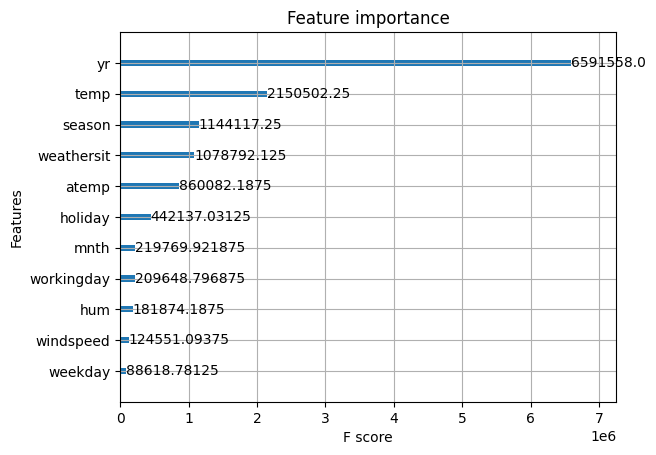

In [11]:
import xgboost
_ = xgboost.plot_importance(xgb_reg, importance_type='gain')

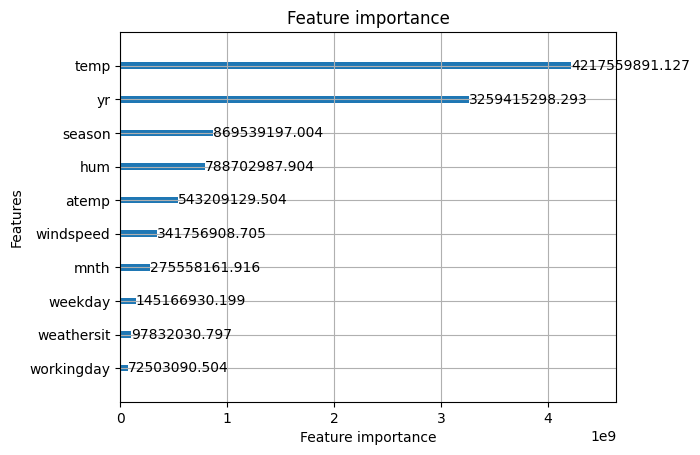

In [12]:
import lightgbm
_ = lightgbm.plot_importance(lgbm_reg, importance_type='gain')

XGBooster와 비슷하게 lightgbm에서도 훈련된 개별 트리를 관찰할 수 있다.

In [21]:
booster = lgbm_reg.booster_
dumped = booster.dump_model()

`lightgbm.plot_tree`를 이용하여 부스팅에 사용된 개별 트리의 생김새를 관찰할 수 있다.

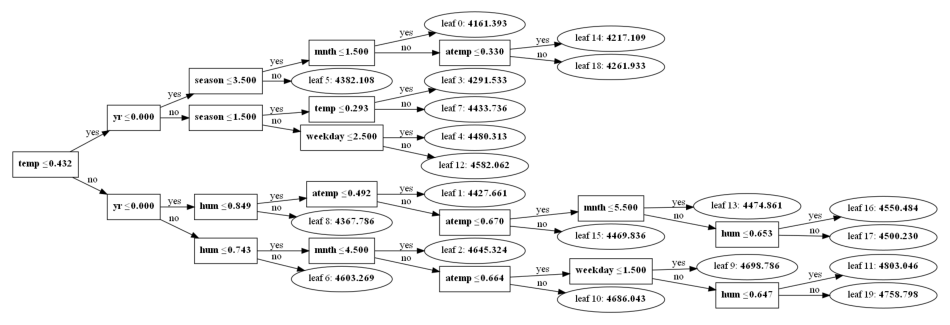

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 10))
lightgbm.plot_tree(booster, tree_index=0, ax=ax)
plt.show()

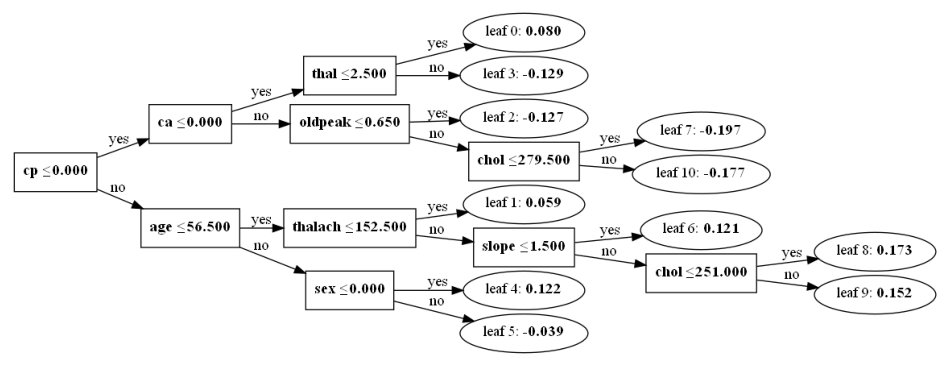

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
lightgbm.plot_tree(booster, tree_index=1, ax=ax)
plt.show()

#### 예제 : 분류 예제

[`lightgbm.LGBMClassifier()`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)를 이용하여 심장병 분류 문제를 다뤄본다.

In [23]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter02/heart_disease.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [24]:
xgb_cl = xgboost.XGBClassifier()
lgbm_cl = lightgbm.LGBMClassifier()

In [25]:
xgb_cl.fit(X, y)
lgbm_cl.fit(X, y)

LGBMClassifier()

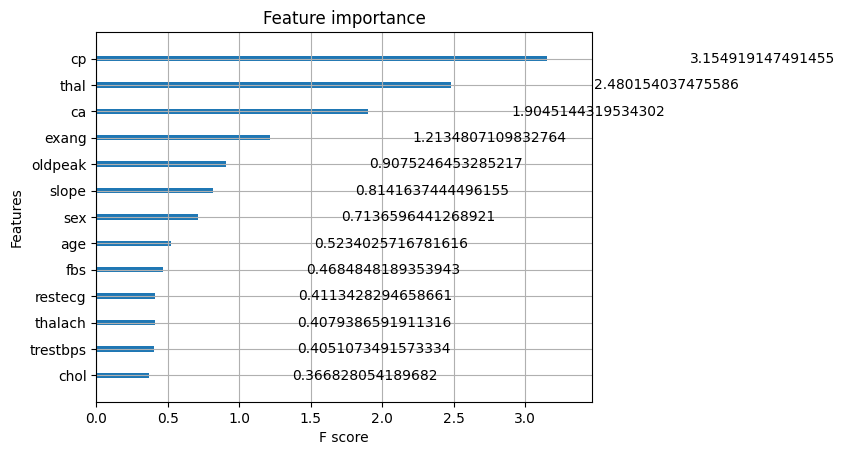

In [26]:
_ = xgboost.plot_importance(xgb_cl, importance_type='gain')

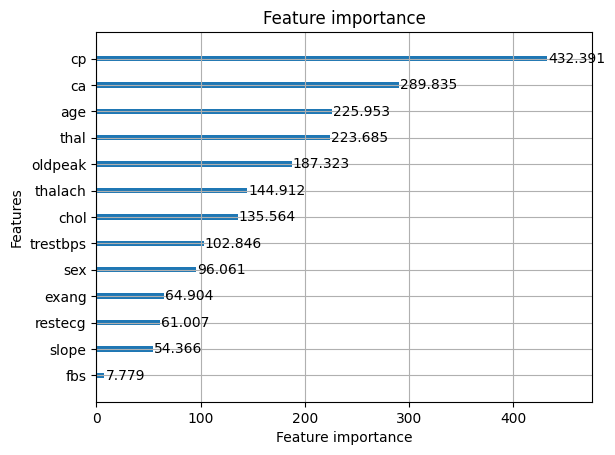

In [27]:
_ = lightgbm.plot_importance(lgbm_cl, importance_type='gain')

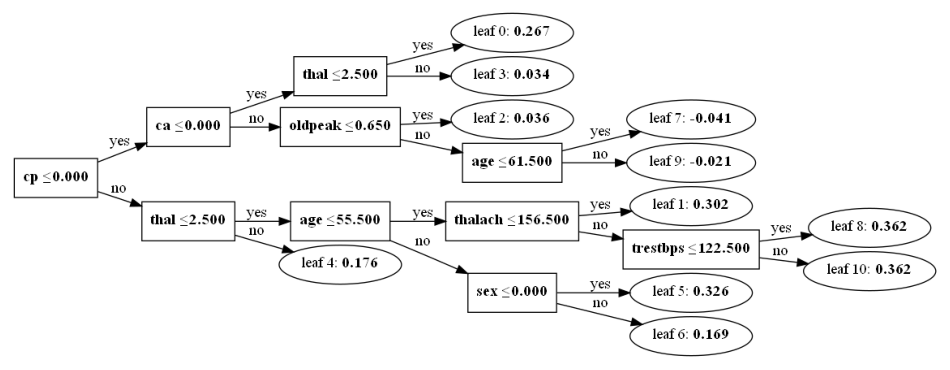

In [28]:
booster = lgbm_cl.booster_
fig, ax = plt.subplots(figsize=(12, 10))
lightgbm.plot_tree(booster, tree_index=0, ax=ax)
plt.show()